#Setup

In [1]:
try:
  # mount your google drive to get permanent storage for your results
  from google.colab import drive
  drive.mount('/content/drive')

  RESULTS_PATH = "/content/drive/MyDrive/infoseclab_ML/results"
except ModuleNotFoundError:
  RESULTS_PATH = "results"

!mkdir -p {RESULTS_PATH}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys

# Lab files
![ ! -d 'infoseclab' ] && git clone https://github.com/ethz-privsec/infoseclab.git
%cd infoseclab
!git pull https://github.com/ethz-privsec/infoseclab.git
%cd ..
if "infoseclab" not in sys.path:
  sys.path.append("infoseclab")

/content/infoseclab
From https://github.com/ethz-privsec/infoseclab
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content


#Imports

In [3]:
import torch
import numpy as np
import infoseclab
from infoseclab import defenses, attacks, ImageNet, EPSILON, utils, evaluation
import os
from zipfile import ZipFile

device = "cuda"

# 0.&nbsp;Untargeted attack on ResNet-50

We will first run an *untargeted* attack, where the goal is to get the model to misclassify an input `(x, y)` as any incorrect class `y'`.

Familiarize yourself with the provided code for a basic PGD attack. The attack is applied to clean images from ImageNet (`ImageNet.clean_images`) with their true labels (`ImageNet.labels`).



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10/10 [00:40<00:00,  4.04s/it]


=== Evaluating untargeted PGD ===
	clean accuracy: 100.0%
	adv accuracy: 0.0% (goal: ≤ 1.0%)
SUCCESS


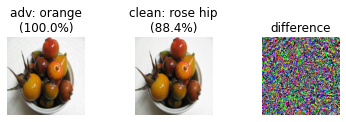

In [ ]:
resnet = defenses.ResNet(device)
pgd = attacks.PGD(steps=20, epsilon=EPSILON, step_size=2.5 * EPSILON / 20, clf=resnet)
x_adv = pgd.attack_all(ImageNet.clean_images, ImageNet.labels, verbose=False)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_untargeted.npy"), x_adv)
evaluation.eval_untargeted_pgd(os.path.join(RESULTS_PATH, "x_adv_untargeted.npy"), device)

idx = 0
input = torch.stack([x_adv[idx], ImageNet.clean_images[idx]]).to(device)
logits = resnet.get_logits(input)
utils.display(x_adv[idx], image_orig=ImageNet.clean_images[idx], logits=logits)

#1.&nbsp;Targeted attack on ResNet-50 

The previous attack lowers the model's accuracy to 0%, but the mistakes are sometimes understandable (e.g., misclassifying a bowl of unripe "rose hips" as "oranges").

You will now implement a *targeted* attack, where the goal is to get the model to misclassify an input `(x, y)` as a *specific* incorrect class `y'`.

For this, you will amend the previous PGD attack to take as input a list of targets `ImageNet.targets` (one target class per input).


In [ ]:
class PGD_Targeted(attacks.PGD):
    """
    A targeted PGD attack.
    """
    
    def __init__(self, steps, epsilon, step_size, clf):
        """
        :param steps: the number of gradient steps to take
        :param epsilon: the maximum perturbation allowed
        :param step_size: the size of the gradient step
        :param clf: the classifier to attack
        """
        super().__init__(steps, epsilon, step_size, clf)

    def attack_batch(self, x, y, verbose=False):
        """
        Attack a batch of images with targeted PGD.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y: the target labels of size (batch_size,)
        :param verbose: whether to print the progress of the attack
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """
        # make a copy of the images that we will perturb
        x_adv = torch.clone(x)

        for i in range(self.steps):
          # we want gradients to flow all the way to the model inputs
          x_adv = x_adv.requires_grad_(True)

          # compute the current loss
          pred = self.clf.get_logits(x_adv)
          loss = torch.nn.CrossEntropyLoss()(pred, y)

          if verbose:
            confidence = torch.exp(-loss)
            print(f"{i}\t loss: {loss.item():.2e}, confidence: {confidence.item():.2e}")

          # compute the gradient of the loss with respect to the input pixels
          # and take an update step in the direction of the signed gradient
          loss.backward()
          grad = x_adv.grad.detach()

          # we don't need any gradients for the rest of the attack
          with torch.no_grad():
            # take a step in the direction of the gradient to maximize the loss
            x_adv = x_adv - self.step_size * torch.sign(grad)

            # project back onto the epsilon ball
            x_adv = self.project(x_adv, x)

        return x_adv.detach()

resnet = defenses.ResNet(device)
pgd_t = PGD_Targeted(steps=20, epsilon=EPSILON, step_size=2.5 * EPSILON / 20, clf=resnet)
x_adv_t = pgd_t.attack_all(ImageNet.clean_images, ImageNet.targets, verbose=False)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_targeted.npy"), x_adv_t)
evaluation.eval_targeted_pgd(os.path.join(RESULTS_PATH, "x_adv_targeted.npy"), device)

100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


=== Evaluating targeted PGD ===
	clean accuracy: 100.0%
	adv accuracy: 0.5% (goal: ≤ 1.0%)
	adv target accuracy: 99.5% (goal: ≥99.0%)
SUCCESS


# 2.&nbsp;Evading Detection

It turns out that "naive" adversarial examples are very easy to *detect*.
So one could build a defense that aims to detect when an input has been perturbed, to reject it and raise an alarm.

Unfortunately, as we'll see such defenses are hard to make robust against an *adaptive* attacker that also optimizes over the detector.

In [ ]:
# Our previous attack is easily detected
evaluation.eval_detector_attack(os.path.join(RESULTS_PATH, "x_adv_targeted.npy"),
                                detector_path="infoseclab/data/detector.pth",
                                device=device)

=== Evaluating targeted PGD with Detection ===
	clean accuracy: 100.0%
	adv accuracy: 0.5% (goal: ≤ 1.0%)
	adv target accuracy: 99.5% (goal: ≥99.0%)
	clean examples detected: 2.5% (goal: ≤5.0%)
	adv examples detected: 97.0% (goal: ≤1.0%)
NOT THERE YET!


You will now implement a targeted attack against the `ResNetDetector` defense.
This defense takes the standard `ResNet` classifier from before, and adds an additional detector module.

The defense can be used for classification, in which case it outputs an array of scores for each of the 1000 classes, for each input:

```
resnet_det = ResNetDetector(device)
resnet_det.get_logits(x) -> [N, 1000]
```

To obtain a detector, we trained a *binary* classifier that takes in an input and outputs binary logits for the task of distinguishing clean images (class 0) from adversarially perturbed ones (class 1):

```
resnet_det = ResNetDetector(device)
resnet_det.get_detection_logits(x) -> [N, 2]
```

*(the classifier and detector actually share most of their implementation.
The original ResNet classifier is of the form `g(f(x))` where `f` is a <u>feature extractor</u> that maps inputs to feature vectors, and `g` is a <u>linear layer</u> that maps a feature vector to a vector of 1000 class scores.
The detector takes as input the same feature vector `f(x)`, and applies a different linear layer `g_det` that maps the features to a vector of 2 class scores.
See `infoseclab.defenses.defense_detector.ResNetDetector` for details).*

Note: You are allowed to use the `ResNetDetector` module in your attack, but you are not allowed to modify it.

In [ ]:
resnet_det = infoseclab.defenses.defense_detector.ResNetDetector(device)

In [ ]:
class PGD_Det(attacks.PGD):
    """
    A targeted PGD attack that also tries to evade detection.
    """
    
    def __init__(self, defense_det, steps, epsilon, step_size, clf):
        """
        :param steps: the number of gradient steps to take
        :param epsilon: the maximum perturbation allowed
        :param step_size: the size of the gradient step
        :param clf: the classifier to attack
        """
        self.defense_det = defense_det
        super().__init__(steps, epsilon, step_size, clf)

    def attack_batch(self, x, y, verbose=False):
        """
        Attack a batch of images with targeted PGD while also evading detection.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y_targets: the target labels of size (batch_size,)
        :param verbose: whether to print the progress of the attack
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """
        # make a copy of the images that we will perturb
        x_adv = torch.clone(x)

        zero = torch.zeros(20, dtype=torch.int64).cuda()
        

        for i in range(self.steps):
          # we want gradients to flow all the way to the model inputs
          x_adv = x_adv.requires_grad_(True)

          # compute the current loss
          pred = self.clf.get_logits(x_adv)
          loss = torch.nn.CrossEntropyLoss()(pred, y)
          #pred2 = self.defense_det.get_logits(x_adv) ##torch.Size([20, 1000])
          pred3 = self.defense_det.get_detection_logits(x_adv) #torch.Size([20, 2])
          #temp = torch.argmax(pred3, dim=-1) #torch.Size([20])
          
          loss2 = torch.nn.CrossEntropyLoss()(pred3, zero)

          loss += loss2

          # print("pred2: ", end="")
          # print(pred2)
          # print(pred2.size())

          # print("pred3: ", end="")
          # print(pred3)
          # print(pred3.size())

          # print("temp: ", end="")
          # print(temp)
          # print(temp.size())

          

          # print("y: ", end="")
          # # print(y)
          # print(y.size())

          # print("pred dim: ", end="")
          # print(pred.size())
          # print("pred2 dim: ", end="")
          # print(pred2.size())

          # loss += loss2

          if verbose:
            confidence = torch.exp(-loss)
            print(f"{i}\t loss: {loss.item():.2e}, confidence: {confidence.item():.2e}")

          # compute the gradient of the loss with respect to the input pixels
          # and take an update step in the direction of the signed gradient
          loss.backward()
          grad = x_adv.grad.detach()

          # we don't need any gradients for the rest of the attack
          with torch.no_grad():
            # take a step in the direction of the gradient to maximize the loss
            x_adv = x_adv - self.step_size * torch.sign(grad)

            # project back onto the epsilon ball
            x_adv = self.project(x_adv, x)

        return x_adv.detach()

resnet = defenses.ResNet(device)
defense_det = defenses.ResNetDetector(device, detector_path="infoseclab/data/detector.pth")
pgd_det = PGD_Det(defense_det, steps=20, epsilon=EPSILON, step_size=2.5 * EPSILON / 20, clf=resnet)
x_adv_det = pgd_det.attack_all(ImageNet.clean_images, ImageNet.targets, verbose=False)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_detect.npy"), x_adv_det)
evaluation.eval_detector_attack(os.path.join(RESULTS_PATH, "x_adv_detect.npy"), device=device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


=== Evaluating targeted PGD with Detection ===
	clean accuracy: 100.0%
	adv accuracy: 0.0% (goal: ≤ 1.0%)
	adv target accuracy: 100.0% (goal: ≥99.0%)
	clean examples detected: 2.5% (goal: ≤5.0%)
	adv examples detected: 0.0% (goal: ≤1.0%)
SUCCESS


#3.&nbsp; Preprocessing Defenses (pick one!)

We are now going to look at two simple defenses against adversarial examples that aim to resist noise by *pre-processing* the input before classifying it.

**Your goal is to break <u>ONE</u> of these two defenses (you can choose which one you prefer)!**

<ul>
  <li> 3.1. JPEG Compression </li>
  <li> 3.2. Random cropping and noising </li>
<ul>

##3.1&nbsp; JPEG Compression

A natural defense idea is to try and remove the noise from adversarial images. A simple way of trying to do that is to compress images before classifying them, e.g., with JPEG.

The `ResNetJPEG` defense implements this.

In [ ]:
# Neither of our attacks survives JPEG compression
evaluation.eval_jpeg_attack(os.path.join(RESULTS_PATH, "x_adv_targeted.npy"), device)
evaluation.eval_jpeg_attack(os.path.join(RESULTS_PATH, "x_adv_detect.npy"), device)

Your goal is to create a targeted PGD attack that will defeat JPEG compression.
In this part, you **don't** need to ensure that the attack stays undetected.

**For this attack (<u>and only for this attack</u>), you are allowed to import additional modules from GitHub if you want. However, you are not allowed to use any external modules that implement adversarial examples attacks (e.g., cleverhans, foolbox, etc.)</br>
If you're unsure if a module is ok to use, please ask!**

External modules can be added in different ways:
*   using PIP: `!pip install XXX`
*   by cloning a github repository locally (replace the git URL and RESPOSITORY_NAME accordingly):

```
!git clone {URL}
if {RESPOSITORY_NAME} not in sys.path:
  sys.path.append("{RESPOSITORY_NAME}")
```



In [ ]:
class PGD_JPEG(attacks.PGD):
    """
    A targeted PGD attack that tries to resist JPEG compression.
    """

    def __init__(self, steps, epsilon, step_size, clf):
        """
        :param steps: the number of gradient steps to take
        :param epsilon: the maximum perturbation allowed
        :param step_size: the size of the gradient step
        :param clf: the classifier to attack
        """
        super().__init__(steps, epsilon, step_size, clf)

        
    def attack_batch(self, x, y_targets, verbose=False):
        """
        Attack a batch of images with targeted PGD while also resisting JPEG compression.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y_targets: the target labels of size (batch_size,)
        :param verbose: whether to print the progress of the attack
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """

        raise NotImplementedError()

defense = defenses.ResNetJPEG(device)
pgd_jpeg = PGD_JPEG(TODO)
x_adv_jpeg = pgd_jpeg.attack_all(ImageNet.clean_images, ImageNet.targets, verbose=False)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_jpeg.npy"), x_adv_jpeg)
evaluation.eval_jpeg_attack(os.path.join(RESULTS_PATH, "x_adv_jpeg.npy"), device)

##3.2&nbsp; Randomized cropping and noising

Another natural defense idea is to try and *randomize* the model's behavior to make it harder to create adversarial examples.

The ResNetRandom defense implements this, by randomly cropping and noising input images before classifying them.

In [ ]:
# Neither of our attacks survive random preprocessing
evaluation.eval_random_attack(os.path.join(RESULTS_PATH, "x_adv_targeted.npy"), device)
evaluation.eval_random_attack(os.path.join(RESULTS_PATH, "x_adv_detect.npy"), device)

Your goal is to create a targeted PGD attack that will defeat randomized pre-processing.
In this part, you **don't** need to ensure that the attack stays undetected.

**Note that since this defense is randomized, the evaluation results might vary slightly from one run to the next. To make sure that your attack passes our final evaluation, try to create an attack that has a few % of slack compared to the evaluation targets (e.g., if we target an adversarial accuracy below 5%, aim to ensure that your attack reaches ~3% or lower)**

In [4]:
class PGD_Random(attacks.PGD):
    """
    A PGD attack that also tries to resist random preprocessing.
    """

    def __init__(self, steps, epsilon, step_size, clf):
        super().__init__(steps, epsilon, step_size, clf)
        
    def attack_batch(self, x, y, verbose=False):
        """
        Attack a batch of images with targeted PGD while also evading random preprocessing.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y_targets: the target labels of size (batch_size,)
        :param verbose: whether to print the progress of the attack
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """
        # make a copy of the images that we will perturb
        x_adv = torch.clone(x)

        for i in range(self.steps):
          # we want gradients to flow all the way to the model inputs
          x_adv = x_adv.requires_grad_(True)

        
          # compute the current loss
          pred = self.clf.get_logits(x_adv)
          loss = torch.nn.CrossEntropyLoss()(pred, y)
          torch.cuda.empty_cache()

          del pred
          torch.cuda.empty_cache()
          pred = self.clf.get_logits(x_adv)
          loss += torch.nn.CrossEntropyLoss()(pred, y)

          del pred
          torch.cuda.empty_cache()
          pred = self.clf.get_logits(x_adv)
          loss += torch.nn.CrossEntropyLoss()(pred, y)

          del pred
          torch.cuda.empty_cache()
          pred = self.clf.get_logits(x_adv)
          loss += torch.nn.CrossEntropyLoss()(pred, y)

          del pred
          torch.cuda.empty_cache()
          pred = self.clf.get_logits(x_adv)
          loss += torch.nn.CrossEntropyLoss()(pred, y)

          del pred
          torch.cuda.empty_cache()
          pred = self.clf.get_logits(x_adv)
          loss += torch.nn.CrossEntropyLoss()(pred, y)

          del pred
          torch.cuda.empty_cache()
          pred = self.clf.get_logits(x_adv)
          loss += torch.nn.CrossEntropyLoss()(pred, y)

          del pred
          torch.cuda.empty_cache()
          pred = self.clf.get_logits(x_adv)
          loss += torch.nn.CrossEntropyLoss()(pred, y)

          # del pred
          # torch.cuda.empty_cache()
          # pred = self.clf.get_logits(x_adv)
          # loss += torch.nn.CrossEntropyLoss()(pred, y)

          # del pred
          # torch.cuda.empty_cache()
          # pred = self.clf.get_logits(x_adv)
          # loss += torch.nn.CrossEntropyLoss()(pred, y)

          # del pred
          # torch.cuda.empty_cache()
          # pred = self.clf.get_logits(x_adv)
          # loss += torch.nn.CrossEntropyLoss()(pred, y)
          
          # for j in range(4):
          #   del pred
          #   torch.cuda.empty_cache()
          #   pred = self.clf.get_logits(x_adv)
          #   loss += torch.nn.CrossEntropyLoss()(pred, y)

          if verbose:
            confidence = torch.exp(-loss)
            print(f"{i}\t loss: {loss.item():.2e}, confidence: {confidence.item():.2e}")

          # compute the gradient of the loss with respect to the input pixels
          # and take an update step in the direction of the signed gradient
          loss.backward()
          grad = x_adv.grad.detach()

          # we don't need any gradients for the rest of the attack
          with torch.no_grad():
            # take a step in the direction of the gradient to maximize the loss
            x_adv = x_adv - self.step_size * torch.sign(grad)

            # project back onto the epsilon ball
            x_adv = self.project(x_adv, x)

        return x_adv.detach()
        raise NotImplementedError()


defense = defenses.ResNetRandom(device)
pgd_random = PGD_Random(steps=20, epsilon=EPSILON, step_size=1, clf=defense)
x_adv_random = pgd_random.attack_all(ImageNet.clean_images, ImageNet.targets, verbose=False)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_random.npy"), x_adv_random)
evaluation.eval_random_attack(os.path.join(RESULTS_PATH, "x_adv_random.npy"), device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10/10 [06:14<00:00, 37.43s/it]


=== Evaluating targeted PGD on random defense ===
	clean accuracy: 98.0%
	adv accuracy: 0.0% (goal: ≤ 5.0%)
	adv target accuracy: 100.0% (goal: ≥95.0%)
SUCCESS


# Create submission file (**upload `results.zip` to moodle**)

In [5]:
!zip -j -r "{RESULTS_PATH}/results.zip" {RESULTS_PATH} --exclude "*x_adv_untargeted.npy"

updating: extraction.json (deflated 25%)
updating: x_adv_targeted.npy (deflated 10%)
updating: x_adv_detect.npy (deflated 10%)
updating: x_adv_random.npy (deflated 10%)


In [6]:
from infoseclab.evaluation import eval_targeted_pgd, eval_detector_attack, eval_jpeg_attack, eval_random_attack
with ZipFile(f"{RESULTS_PATH}/results.zip", 'r') as zip:
    eval_targeted_pgd(path=zip.open("x_adv_targeted.npy"), device=device)
    eval_detector_attack(path=zip.open("x_adv_detect.npy"), device=device)
    #eval_jpeg_attack(path=zip.open("x_adv_jpeg.npy"), device=device)
    eval_random_attack(path=zip.open("x_adv_random.npy"), device=device)

=== Evaluating targeted PGD ===
	clean accuracy: 100.0%
	adv accuracy: 0.5% (goal: ≤ 1.0%)
	adv target accuracy: 99.5% (goal: ≥99.0%)
SUCCESS
=== Evaluating targeted PGD with Detection ===
	clean accuracy: 100.0%
	adv accuracy: 0.0% (goal: ≤ 1.0%)
	adv target accuracy: 100.0% (goal: ≥99.0%)
	clean examples detected: 2.5% (goal: ≤5.0%)
	adv examples detected: 0.0% (goal: ≤1.0%)
SUCCESS
=== Evaluating targeted PGD on random defense ===
	clean accuracy: 97.0%
	adv accuracy: 0.0% (goal: ≤ 5.0%)
	adv target accuracy: 100.0% (goal: ≥95.0%)
SUCCESS
